In [ ]:
# Install Packages with pip
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install ultralytics==8.0.134

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-a0pu9lkb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-a0pu9lkb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=b9b53dbdac25d124d21d64a0add938cd90a9ff45a9a0250e6d461194e0193414
  Stored in directory: /tmp/pip-ephem-wheel-cache-kg94mnzh/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Import Packages
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

In [ ]:
# SAM function
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [ ]:
# Calculate IoU function
def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = max(inter_height, 0) * max(inter_width, 0)
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    # compute the IoU
    iou = inter_area / union_area
    return iou

In [ ]:
# Setting models paths
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "drive/MyDrive/SAM/sam_vit_h_4b8939.pth" #Path to SAM checkpoint
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
model_win = YOLO("/content/drive/MyDrive/YOLOv8/Windows/best.pt") #Path to YOLOv8s weights for windows detection
model_base = YOLO("/content/drive/MyDrive/YOLOv8/Basement/best.pt") #Path to YOLOv8s weights for basement, door, garage detection


0: 768x1024 6 windows, 20.6ms
Speed: 3.2ms preprocess, 20.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict

0: 768x1024 1 basement, 2 doors, 13.6ms
Speed: 4.0ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict2


(768, 1024)
(768, 1024)
(768, 1024)


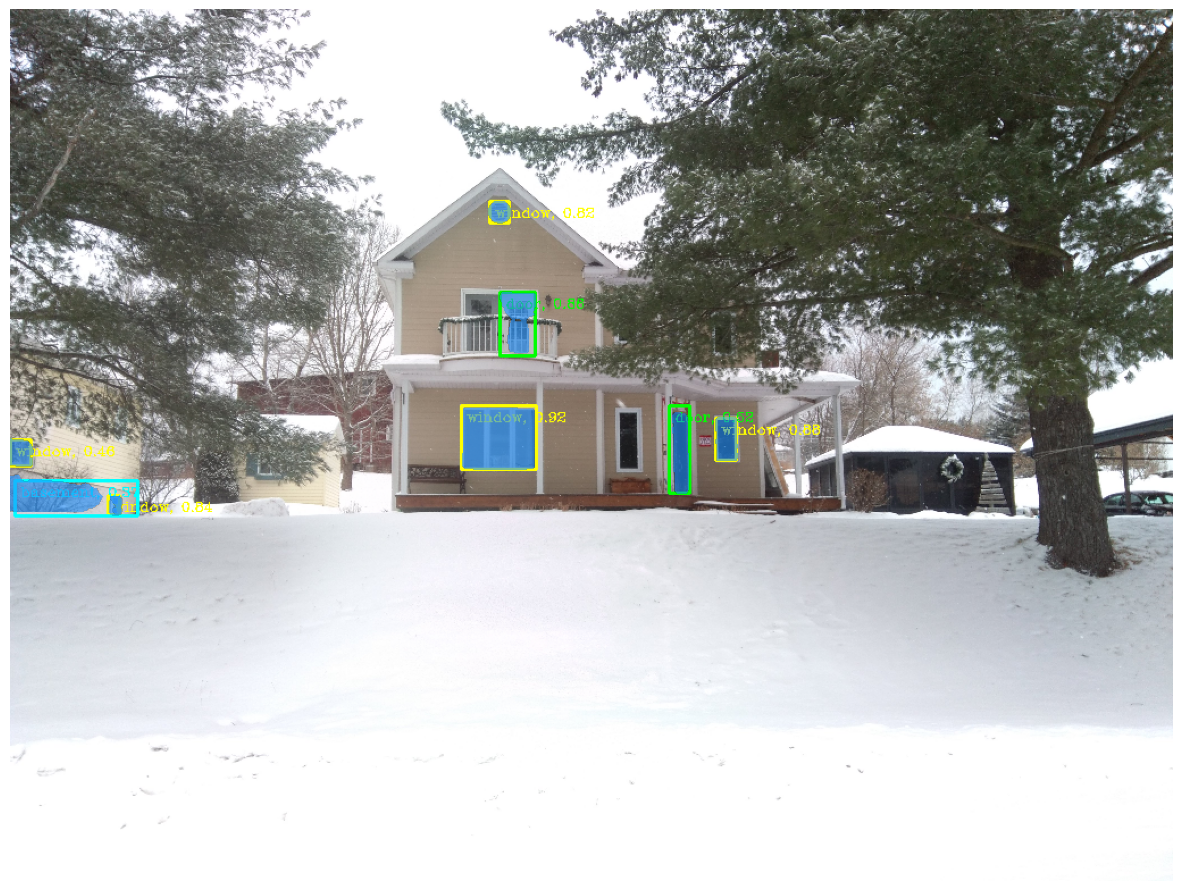

In [ ]:
path = 'drive/MyDrive/SAM/test18.jpg' #Path to image
image = cv2.imread(path)
image1 = cv2.resize(image, (1024,768))
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

objects_win = model_win(image1, save = True) # Windows detection
objects_base = model_base(image1, save = True) # Garage, basement, door detection

for obj in objects_win :
    boxes = obj.boxes
    boxes1 = boxes.data

for obj in objects_base :
    boxes = obj.boxes
    boxes2 = boxes.data

masks_windows = []
class_names = ['basement', 'door', 'garage']
coords = []
# Calculate the IoU between doors and windows, if IoU > 0.2 : add the box with less precision to coords list
for boxe1 in boxes1 :
    box1 = boxe1[:4].tolist()
    precision1 = round(boxe1[4].tolist(), 2)
    for boxe2 in boxes2 :
        class_name = class_names[int(boxe2[5].tolist())]
        box2 = boxe2[:4].tolist()
        precision2 = round(boxe2[4].tolist(), 2)
        if class_name == 'door' and iou(box1, box2) > 0.2:
          if precision1 > precision2 :
            coords.append(box2)
          else :
            coords.append(box1)
# Windows segmentation
for boxe in boxes1 :
    class_name = 'window'
    x1, y1, x2, y2 = boxe[:4].tolist()
    if [x1, y1, x2, y2] in coords : # Not take into account box in coords list
      continue
    precision = round(boxe[4].tolist(), 2)
    color = (255,255,0)
    cv2.rectangle(image, ((int(x1), int(y1))), ((int(x2), int(y2))), color, 2)
    # Add text to the rectangle
    text = f'{class_name}, {precision}'
    font = cv2.FONT_HERSHEY_COMPLEX
    font_scale = 0.4
    thickness = 1
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_x = int(x1 + 5)
    text_y = int(y1 + text_size[1] + 5)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)
    # SAM Model
    input_box = np.array(boxe[:4].tolist())
    masks, scores, logits = predictor.predict(
        point_coords= None,
        point_labels= None,
        box=input_box[None, :],
        multimask_output= True,
    )
    masks_windows.append(masks)
# Garage, basement, door segmentation
for boxe in boxes2 :
    class_name = class_names[int(boxe[5].tolist())]
    x1, y1, x2, y2 = boxe[:4].tolist()
    if [x1, y1, x2, y2] in coords : # Not take into account box in coords list
      continue
    precision = round(boxe[4].tolist(), 2)
    if class_name == 'garage' :
        color = (255,0,0)
    elif class_name == 'door' :
        color = (0,255,0)
    elif class_name == 'basement' :
        color = (0,255,255)
    cv2.rectangle(image, ((int(x1), int(y1))), ((int(x2), int(y2))), color, 2)
    # Add text to the rectangle
    text = f'{class_name}, {precision}'
    font = cv2.FONT_HERSHEY_COMPLEX
    font_scale = 0.4
    thickness = 1
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_x = int(x1 + 5)
    text_y = int(y1 + text_size[1] + 5)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)
    # SAM Model
    input_box = np.array(boxe[:4].tolist())
    masks, scores, logits = predictor.predict(
        point_coords= None,
        point_labels= None,
        box=input_box[None, :],
        multimask_output= True,
    )
    masks_windows.append(masks)
# Plot results
plt.figure(figsize=(15,15))
plt.imshow(image)
for mask in masks_windows :
    show_mask(mask[0], plt.gca())
plt.axis('off')
plt.savefig('output.png')
plt.show()